In [1]:
import tensorflow_hub as hub
import os
import numpy as np
import glob
import shutil

import tensorflow as tf

import matplotlib.pyplot as plt

In [2]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense

In [3]:
base_dir = '/Users/anasarodake/anas_fotos'
classes = ['lachen' , 'neutral']


for cl in classes:
    img_path = os.path.join(base_dir, cl)
    images = glob.glob(img_path + '/*.jpeg')
    print("{}: {} Images".format(cl, len(images)))
    train, val = images[:round(len(images)*0.7)], images[round(len(images)*0.7):]

    for t in train:
      if not os.path.exists(os.path.join(base_dir, 'train', cl)):
        os.makedirs(os.path.join(base_dir, 'train', cl))
      shutil.move(t, os.path.join(base_dir, 'train', cl))

    for v in val:
      if not os.path.exists(os.path.join(base_dir, 'val', cl)):
        os.makedirs(os.path.join(base_dir, 'val', cl))
      shutil.move(v, os.path.join(base_dir, 'val', cl))




lachen: 0 Images
neutral: 0 Images


In [4]:
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')


In [5]:
IMG_SHAPE = 250

batch_size =10

image_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    zoom_range=0.5,
    horizontal_flip=True,
    width_shift_range=0.15,
    height_shift_range=0.15
)

train_data_gen = image_gen.flow_from_directory(
    directory=train_dir,
    shuffle=True,
    target_size = (IMG_SHAPE, IMG_SHAPE),
    batch_size= batch_size,
    class_mode='sparse',
    classes=classes
)

def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()




Found 550 images belonging to 2 classes.


In [6]:
#dieser ablock sucht nach Bildern, die evtl. einen Fehler bei ber Implimentierung verursachen und zeigt sie auf
import PIL
from pathlib import Path
from PIL import UnidentifiedImageError
path = Path(train_dir).rglob("*.jpeg")
for img_p in path:
    try:
        img = PIL.Image.open(img_p)
    except PIL.UnidentifiedImageError:
        print(img_p)

In [7]:
#augmented_images = [train_data_gen[0][0][0] for i in range(5)]
#plotImages(augmented_images)

In [8]:
image_gen = ImageDataGenerator(
    rescale=1./255
)


val_data_gen =  image_gen.flow_from_directory(
    directory=val_dir,
    classes=classes,
    target_size = (IMG_SHAPE, IMG_SHAPE),
    batch_size= batch_size,
    class_mode= 'sparse')



Found 191 images belonging to 2 classes.


In [9]:
model = Sequential()

model.add(Conv2D(4,3 , padding='same' , input_shape=(IMG_SHAPE, IMG_SHAPE, 3) , activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Conv2D(16, 3 ,padding='same' , activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, 3 ,padding='same' , activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))




model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model.add(Dropout(0.4))

model.add(Dense(1024 ,  activation='relu'))

model.add(Dropout(0.4))
model.add(Dense(2, activation='softmax'))



Metal device set to: Apple M1


2022-04-14 23:09:43.433663: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-04-14 23:09:43.433984: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [10]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy']
              )

In [11]:
from tensorflow.python.keras.callbacks import EarlyStopping
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss' , patience= 3 , verbose=1)

epochs = 120
history = model.fit(
    train_data_gen,
    steps_per_epoch=int(np.ceil(train_data_gen.n / float(batch_size))), #alle Bilder / 10
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=int(np.ceil(val_data_gen.n / float(batch_size))),
    #callbacks=[callback]
)


Epoch 1/120


2022-04-14 23:09:44.233295: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
/Users/anasarodake/miniforge3/lib/python3.9/site-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)
2022-04-14 23:09:44.524767: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


55/55 [==============================] - ETA: 0s - loss: 0.7016 - accuracy: 0.5491

2022-04-14 23:09:50.836883: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


55/55 [==============================] - 8s 110ms/step - loss: 0.7016 - accuracy: 0.5491 - val_loss: 0.6849 - val_accuracy: 0.5916
Epoch 2/120
55/55 [==============================] - 5s 97ms/step - loss: 0.6899 - accuracy: 0.5764 - val_loss: 0.6785 - val_accuracy: 0.5916
Epoch 3/120
55/55 [==============================] - 5s 96ms/step - loss: 0.6825 - accuracy: 0.5764 - val_loss: 0.6766 - val_accuracy: 0.5916
Epoch 4/120
55/55 [==============================] - 6s 101ms/step - loss: 0.6673 - accuracy: 0.5873 - val_loss: 0.6089 - val_accuracy: 0.6963
Epoch 5/120
55/55 [==============================] - 7s 122ms/step - loss: 0.6455 - accuracy: 0.5836 - val_loss: 0.4483 - val_accuracy: 0.8586
Epoch 6/120
55/55 [==============================] - 7s 130ms/step - loss: 0.6587 - accuracy: 0.5927 - val_loss: 0.4392 - val_accuracy: 0.8168
Epoch 7/120
55/55 [==============================] - 7s 121ms/step - loss: 0.5802 - accuracy: 0.6673 - val_loss: 0.3952 - val_accuracy: 0.8010
Epoch 8/120
5

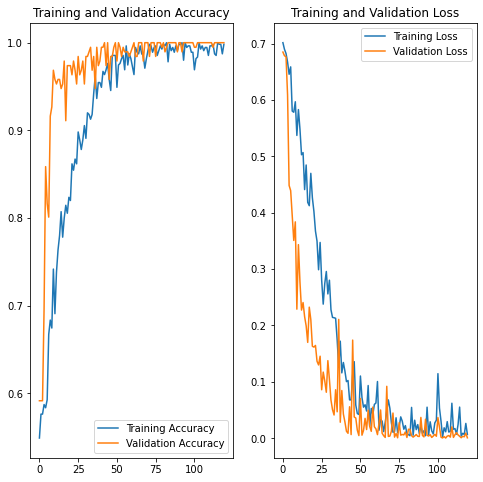

In [12]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
 
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [13]:
#classes = ['lachen' , 'neutral']

In [14]:
test_dir = os.path.join(base_dir, 'test')

image_gen = ImageDataGenerator(
    rescale=1./255
)


test_data_gen =  image_gen.flow_from_directory(
    directory=test_dir,
    classes=classes,
    target_size = (IMG_SHAPE, IMG_SHAPE),
    batch_size= batch_size,
    class_mode= 'sparse')



evaluated = model.evaluate(
    x = test_data_gen
)

Found 14 images belonging to 2 classes.
2/2 [==============================] - 1s 740ms/step - loss: 8.3755e-04 - accuracy: 1.0000


In [15]:
predict_dir_lach = os.path.join(base_dir, 'oli/lachen')

image_gen = ImageDataGenerator(
    rescale=1./255
)


predict_lach_data_gen =  image_gen.flow_from_directory(
    directory=predict_dir_lach,

    target_size = (IMG_SHAPE, IMG_SHAPE),
    batch_size= 86,
    class_mode= 'sparse'
    )



predicted_lach = model.predict(x = predict_lach_data_gen)



for value in predicted_lach:
    print("\nLächeln Bild, die KI Werte:    lachen:{}      Neutral:{}".format( round(value[0] *100 , 2) ,round(value[1] *100) ) , "   richtig geschätzt:  " ,  (value[0] > value[1]) )

Found 28 images belonging to 1 classes.


2022-04-14 23:22:38.209500: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Lächeln Bild, die KI Werte:    lachen:53.6      Neutral:46    richtig geschätzt:   True

Lächeln Bild, die KI Werte:    lachen:100.0      Neutral:0    richtig geschätzt:   True

Lächeln Bild, die KI Werte:    lachen:2.76      Neutral:97    richtig geschätzt:   False

Lächeln Bild, die KI Werte:    lachen:0.35      Neutral:100    richtig geschätzt:   False

Lächeln Bild, die KI Werte:    lachen:100.0      Neutral:0    richtig geschätzt:   True

Lächeln Bild, die KI Werte:    lachen:100.0      Neutral:0    richtig geschätzt:   True

Lächeln Bild, die KI Werte:    lachen:100.0      Neutral:0    richtig geschätzt:   True

Lächeln Bild, die KI Werte:    lachen:99.99      Neutral:0    richtig geschätzt:   True

Lächeln Bild, die KI Werte:    lachen:100.0      Neutral:0    richtig geschätzt:   True

Lächeln Bild, die KI Werte:    lachen:100.0      Neutral:0    richtig geschätzt:   True

Lächeln Bild, die KI Werte:    lachen:0.21      Neutral:100    richtig geschätzt:   False

Lächeln Bild, d

In [16]:
index = 0
false_images = np.array([])
for value in predicted_lach:
    if value[0] < value[1]:
        print("falsch geschätztes BILD:    lachen: {}      Neutral: {}        Bild_Index: {}".format( round(value[0] *100 , 2) ,round(value[1] *100) , index ))
        false_images = np.append(false_images , int(index))
    index = index+1

print("zahl der Falsch geschätzten Bilder: " , len(false_images))

falsch geschätztes BILD:    lachen: 2.76      Neutral: 97        Bild_Index: 2
falsch geschätztes BILD:    lachen: 0.35      Neutral: 100        Bild_Index: 3
falsch geschätztes BILD:    lachen: 0.21      Neutral: 100        Bild_Index: 10
falsch geschätztes BILD:    lachen: 1.59      Neutral: 98        Bild_Index: 13
falsch geschätztes BILD:    lachen: 18.51      Neutral: 81        Bild_Index: 14
falsch geschätztes BILD:    lachen: 1.81      Neutral: 98        Bild_Index: 16
falsch geschätztes BILD:    lachen: 7.01      Neutral: 93        Bild_Index: 17
falsch geschätztes BILD:    lachen: 0.48      Neutral: 100        Bild_Index: 20
falsch geschätztes BILD:    lachen: 6.87      Neutral: 93        Bild_Index: 21
falsch geschätztes BILD:    lachen: 0.05      Neutral: 100        Bild_Index: 24
zahl der Falsch geschätzten Bilder:  10


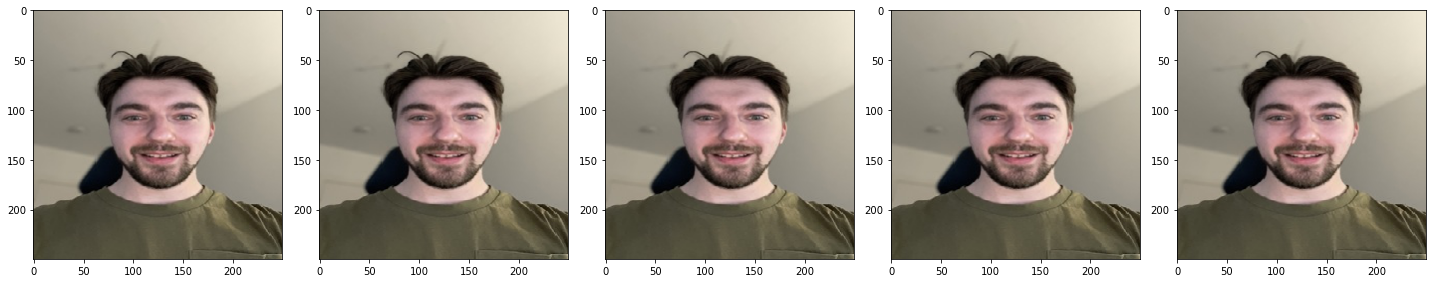

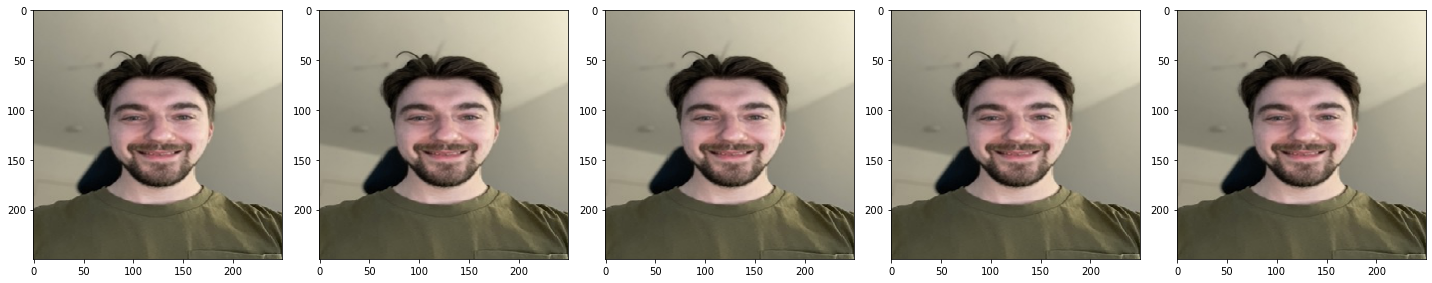

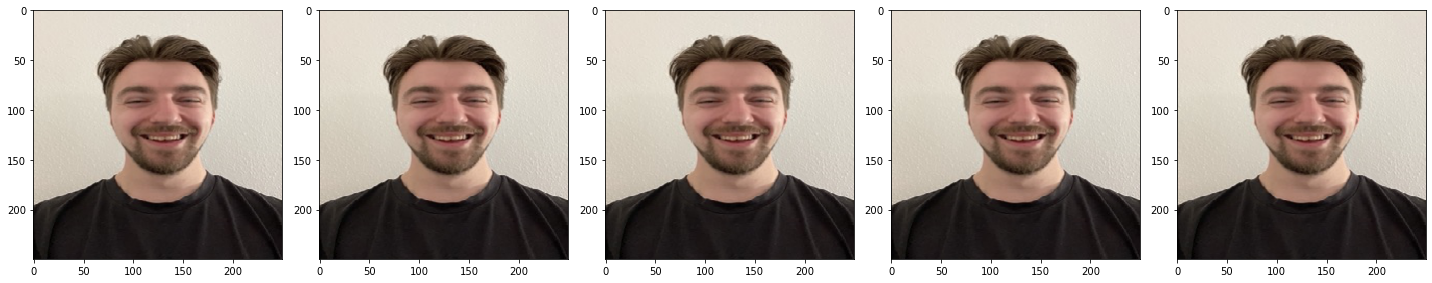

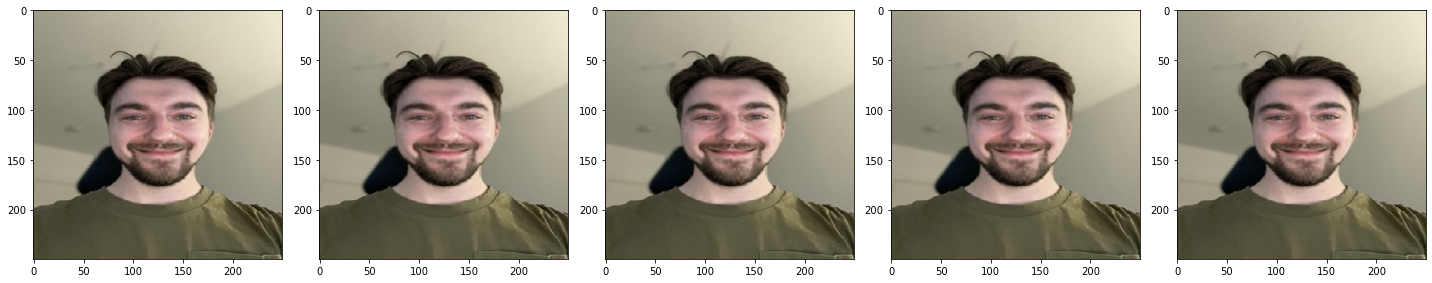

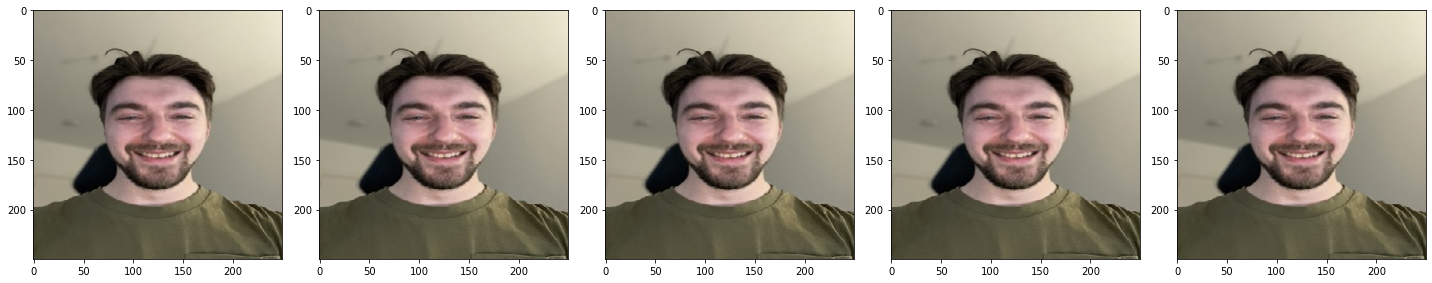

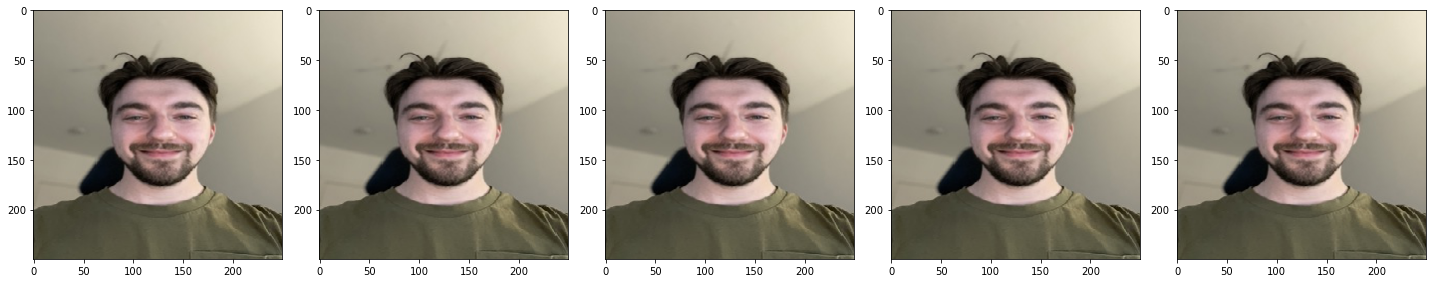

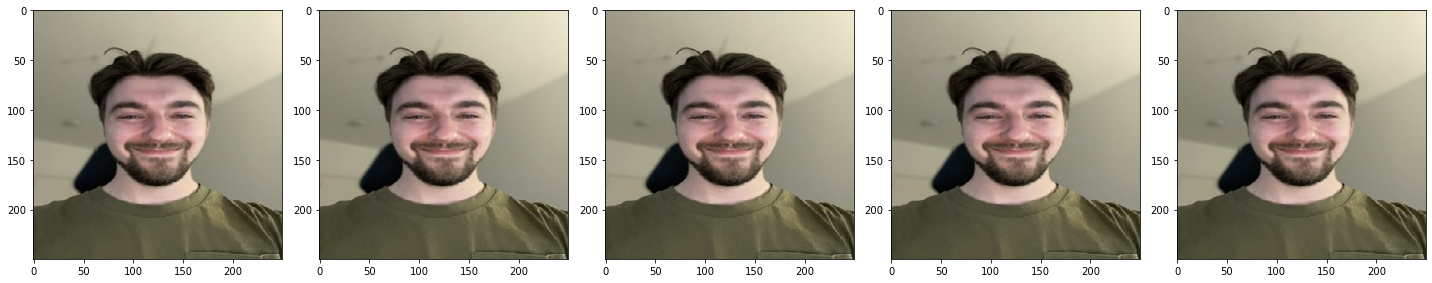

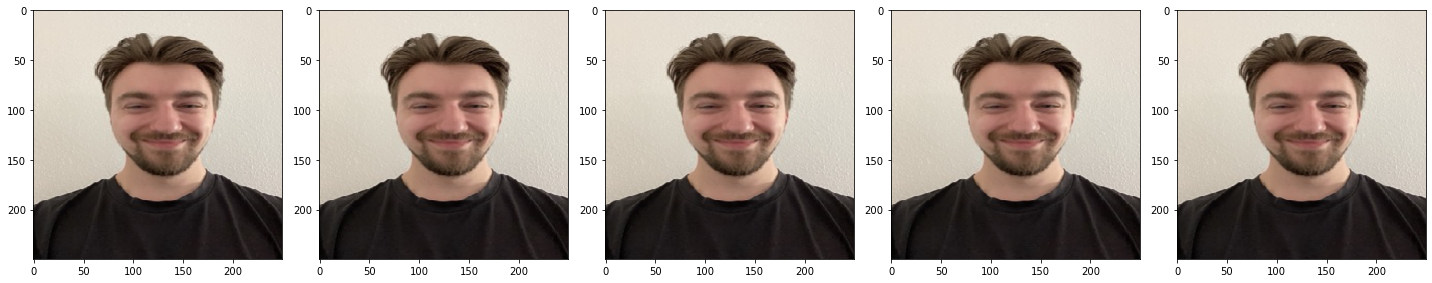

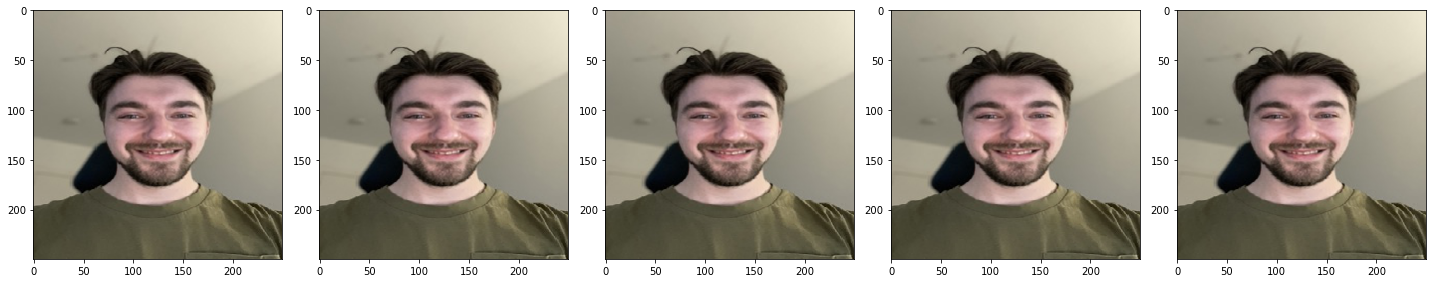

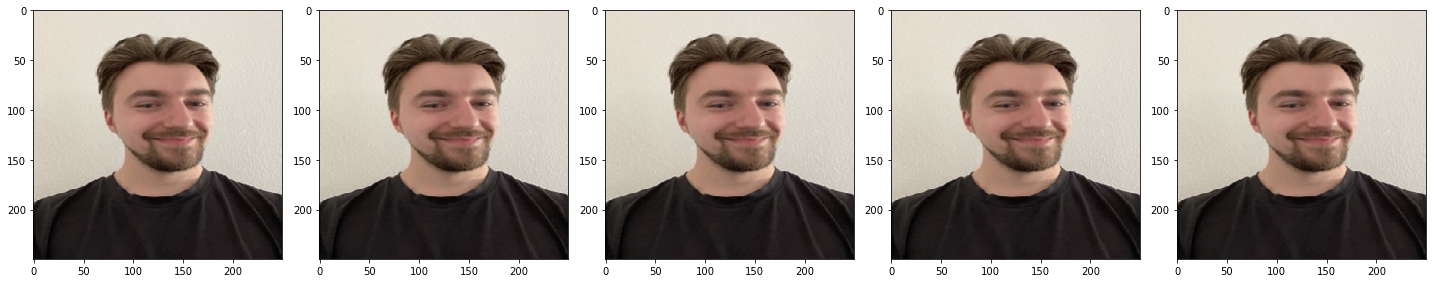

In [17]:
for pic in false_images:
    augmented_images = [predict_lach_data_gen[0][0][int(pic)] for i in range(5)]
    plotImages(augmented_images)


In [18]:
predict_dir = os.path.join(base_dir, 'oli/neutral')

image_gen = ImageDataGenerator(
    rescale=1./255
)


predict_data_gen =  image_gen.flow_from_directory(
    directory=predict_dir,
    #classes=classes,
    target_size = (IMG_SHAPE, IMG_SHAPE),
    batch_size= 43,
    class_mode= 'sparse')



predicted = model.predict(x = predict_data_gen)
for value in predicted:
    print("Neutrales Bild, die KI Werte:   lachen:{}      Neutral:{}".format( round(value[0] *100 , 2) ,round(value[1] *100) ))

Found 9 images belonging to 1 classes.
Neutrales Bild, die KI Werte:   lachen:71.8      Neutral:28
Neutrales Bild, die KI Werte:   lachen:0.05      Neutral:100
Neutrales Bild, die KI Werte:   lachen:2.5      Neutral:97
Neutrales Bild, die KI Werte:   lachen:0.1      Neutral:100
Neutrales Bild, die KI Werte:   lachen:0.34      Neutral:100
Neutrales Bild, die KI Werte:   lachen:0.55      Neutral:99
Neutrales Bild, die KI Werte:   lachen:2.98      Neutral:97
Neutrales Bild, die KI Werte:   lachen:97.98      Neutral:2
Neutrales Bild, die KI Werte:   lachen:2.05      Neutral:98


In [19]:
index = 0
false_images = np.array([])
for value in predicted:
    if value[0] > value[1]:
        print("falsch geschätztes BILD:    lachen: {}      Neutral: {}        Bild_Index: {}".format( round(value[0] *100 , 2) ,round(value[1] *100) , index ))
        false_images = np.append(false_images , int(index))
    index = index+1

falsch geschätztes BILD:    lachen: 71.8      Neutral: 28        Bild_Index: 0
falsch geschätztes BILD:    lachen: 97.98      Neutral: 2        Bild_Index: 7


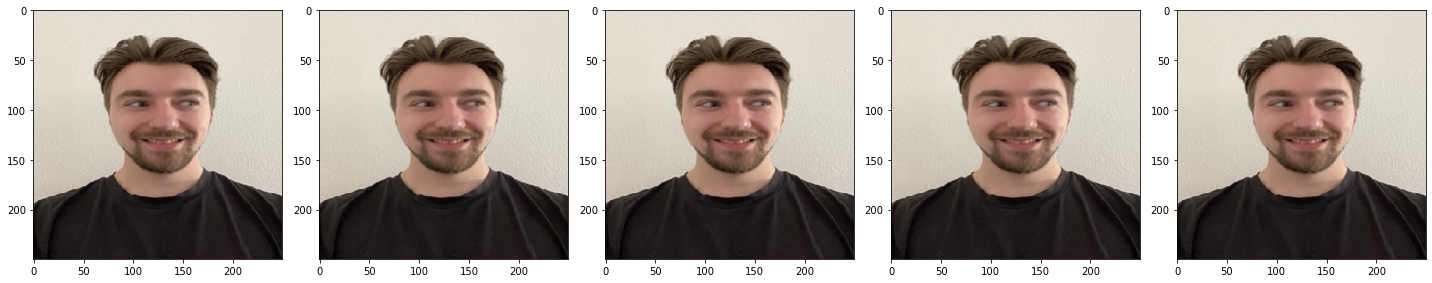

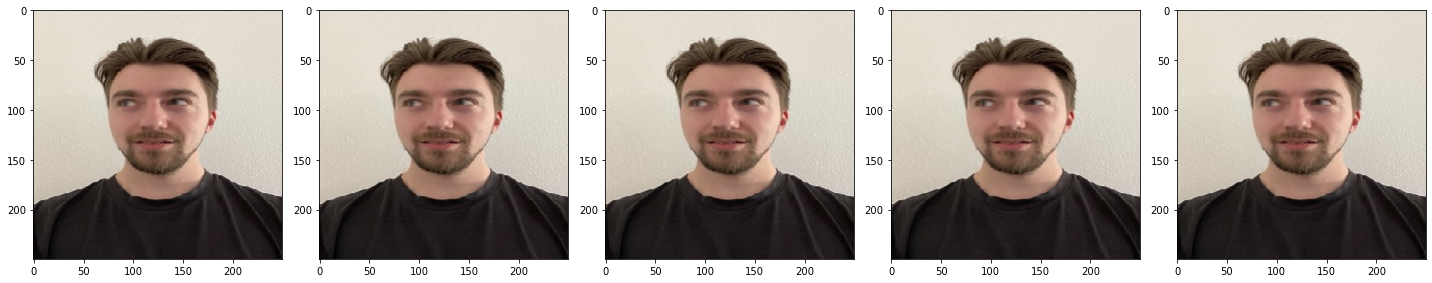

In [20]:
for pic in false_images:
    augmented_images = [predict_data_gen[0][0][int(pic)] for i in range(5)]
    plotImages(augmented_images)

In [21]:
print("zahl der Falsch geschätzten Bilder: " , len(false_images))

zahl der Falsch geschätzten Bilder:  2
